In [86]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from IPython import display

In [2]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')

def load_review(path, is_pos=True):
    with open(path) as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

display.display(pos_review.head(), neg_review.head())

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


,review,sentiment
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0


In [3]:
all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [45]:
import functools
import operator

def get_all_characters(df):
    chars = []
    for review in df.review:
        chars.append(list(review))
    chars = functools.reduce(operator.iconcat, chars, [])
    return list(set(chars))

In [46]:
chars = get_all_characters(all_reviews)

NUM_CHARS = len(chars)
print('Total number of characters: {}\n{}'.format(NUM_CHARS, chars))

Total number of characters: 87
['x', '9', '[', '+', '=', ':', 'ô', 'a', '"', 'h', 'f', 'd', 'j', 'g', '*', '…', 'n', 'ü', 'c', 'é', 'e', '6', 'á', 'ă', '&', '2', 's', 'l', 'u', '%', '–', '.', '/', 'r', '(', 'ű', 'o', 'p', "'", ' ', 'ć', '4', 'É', ';', '?', '-', 'ę', 'č', '—', '5', ']', 'i', '7', 'b', '$', '<', 'w', '!', '3', ',', '8', 't', '˝', 'ú', 'q', '1', ')', '#', '`', 'â', 'ö', 'z', 'ŕ', 'v', 'ń', 'Ú', 'í', '‘', 'ď', '0', 'm', '>', 'k', 'ç', 'y', 'ő', 'ó']


In [37]:
char_to_num = {chars[i]: i for i in range(NUM_CHARS)}
num_to_char = {i: chars[i] for i in range(NUM_CHARS)}

Find the maximum length of review -- padding

In [76]:
def get_max_len(df):
    all_lenghts = []
    for review in df.review:
        all_lenghts.append(len(list(review)))
    return max(all_lenghts)

In [77]:
MAX_LEN = get_max_len(all_reviews)
print('Maximum character length of review: {}'.format(MAX_LEN))

Maximum character length of review: 269


In [82]:
def review_to_one_hot(char):
    one_hot = [0] * NUM_CHARS
    pos = char_to_num[char]
    one_hot[pos] = 1
    return one_hot

def process_review(review, pad=True):
    review = list(review) # to characters
    review_one_hot = [review_to_one_hot(char) for char in review]
    if pad:
        # append 0 value padding
        while len(review_one_hot) < MAX_LEN:
            review_one_hot.append([0] * NUM_CHARS)
    return review_one_hot

In [91]:
t = 'this movie was amazing. great acting with superb soundtracks'

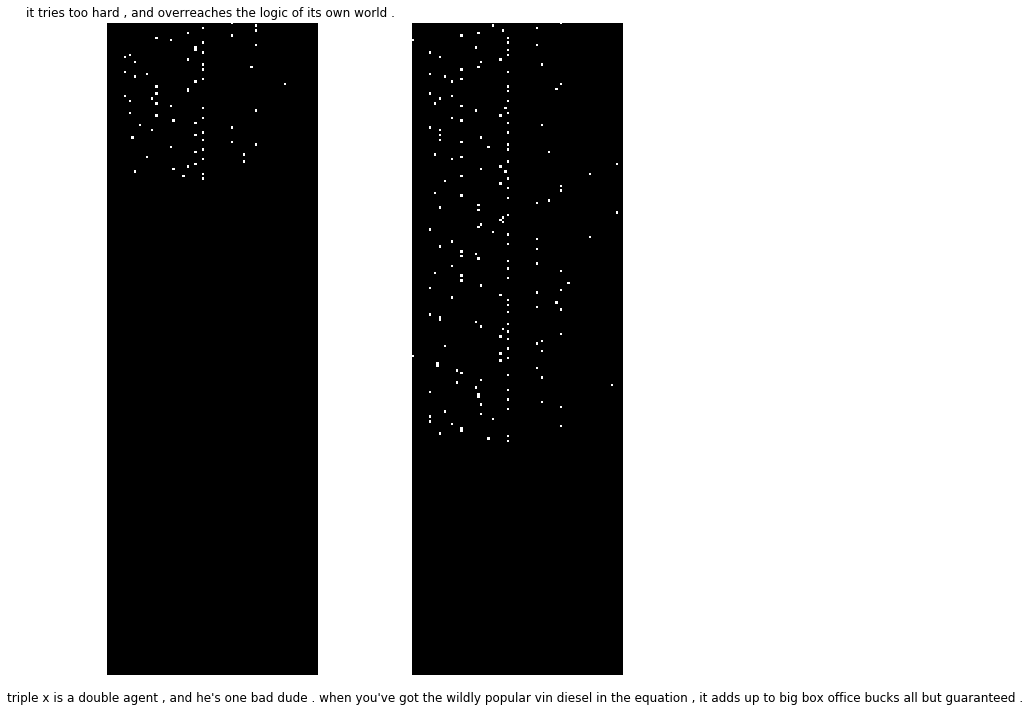

In [116]:
plt.figure(figsize=(10, 12))
plt.subplot(1, 2, 1)
plt.title(neg_review.review.iloc[2345])
plt.imshow([p for p in process_review(neg_review.review.iloc[2345])], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(pos_review.review.iloc[2345], y=-0.05)
plt.imshow([p for p in process_review(pos_review.review.iloc[2345])], cmap='gray')
plt.axis('off')

plt.show()

### TODOs:

- Create train and test dataset 
- Build CNN model
- Tune hyperparameters, also the MAX_LEN?
- Look at each layer weights (some patterns)